### 0. Projeto de Conclusão - Apresentação

MACHINE LEARNING 1
Aluno: Marcello Borges Miranda

World Happiness Report (https://www.kaggle.com/datasets/unsdsn/world-happiness)

Iremos aplicar modelos de Machine Learning para prever o índice de felicidade dos países,
analisando fatores como PIB per capita, expectativa de vida, liberdade, entre outros,
disponíveis no dataset.

Para esta finalidade, iremos utilizar dados referentes ao período de 2015 a 2022.
Como o mesmo país aparece em vários anos, iremos considerar os dados de cada ano como registros separados. Por exemplo, o Canadá em 2016 será tratado como um registro diferente do Canadá em 2017. 

Identificaremos cada registro pela combinação "nome do país"+"-"+"ano" (ex: Canada-2016). Deste modo, partimos de arquivos .csv anuais com aproximadamente 160 países cada,
e construímos um único dataframe com mais de 1000 instâncias.

### 1. Import de lib

Nesta etapa, iremos importar as bibliotecas que serão utilizadas ao longo do projeto.

In [30]:
### 1. Import de lib

# Pandas: manipular dados em formato de tabela
import pandas as pd

# Numpy: operações matemáticas
import numpy as np

# Matplotlib & Seaborn: visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: para divisão dos dados
from sklearn.model_selection import train_test_split

# Ferramentas de pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline: para organizar o fluxo de pré-processamento + modelo
from sklearn.pipeline import Pipeline

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Ferramenta de otimização (Fining Tuning com Grid Search)
from sklearn.model_selection import GridSearchCV

# Métricas de avaliação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Configuração estética dos gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


### 2. Carregamento da Base

Nesta etapa, iremos carregar os arquivos .csv referentes aos anos de 2015 a 2022.
Depois, iremos unir todos os arquivos em um único dataframe, criando também uma
identificação única para cada registro no formato "País-Ano".


In [31]:
### 2. Carregamento da Base

# Lista com os anos disponíveis no dataset
anos = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Dicionário para armazenar os DataFrames por ano
dfs_por_ano = {}

# Loop para carregar os arquivos CSV separadamente
for ano in anos:
    
    # Lê o arquivo CSV dentro da pasta 'data'
    df_ano = pd.read_csv(f"data/{ano}.csv")
    
    # Armazena o DataFrame no dicionário
    dfs_por_ano[ano] = df_ano



### 3. Análise Exploratória

Nesta etapa, iremos realizar uma análise exploratória dos dados com o objetivo de
entender melhor a estrutura dos dataframes e a qualidade das informações disponíveis.

Inicialmente, iremos verificar os rótulos das colunas e identificar os dados
categóricos, garantindo que as mesmas informações estejam corretamente nomeadas
nos diferentes arquivos do dataset.

Em seguida, iremos analisar a presença de dados ausentes (NaN), identificando
quais variáveis possuem valores faltantes.

Como o índice de felicidade é originalmente uma variável contínua, também será
realizada uma análise da sua distribuição e, posteriormente, será criado um
rótulo binário a partir desse índice, para a aplicação de modelos de classificação.

Depois, iremos avaliar o balanceamento das classes por meio da distribuição do
target binário, para entender como os registros estão distribuídos entre as classes.

Na sequência, iremos analisar a distribuição estatística das principais features,
utilizando histogramas e boxplots, com o objetivo de identificar padrões e possíveis
outliers.

Por fim, iremos realizar a análise de correlação entre as variáveis, utilizando
um heatmap, para entender a relação entre as features e o target.


### 3.1 Identificar dados categóricos, target e features principais

Nesta etapa, iremos identificar os rótulos das colunas que representam o nome do país,
o target (nível de felicidade) e as principais variáveis explicativas que serão utilizadas
no modelo. Como os nomes dessas colunas variam entre os arquivos, esse mapeamento será
necessário antes da unificação dos dataframes.



In [32]:
### 3.1 Identificar dados categóricos e rótulos das colunas
for ano, df_ano in dfs_por_ano.items():
    
    print(f"\nColunas do arquivo {ano}.csv:")
    print(df_ano.columns.tolist())



Colunas do arquivo 2015.csv:
['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Standard Error', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']

Colunas do arquivo 2016.csv:
['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']

Colunas do arquivo 2017.csv:
['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high', 'Whisker.low', 'Economy..GDP.per.Capita.', 'Family', 'Health..Life.Expectancy.', 'Freedom', 'Generosity', 'Trust..Government.Corruption.', 'Dystopia.Residual']

Colunas do arquivo 2018.csv:
['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of

In [33]:
# Mapeamento das colunas equivalentes entre os arquivos

# Colunas que representam o nome do país (dado categórico)
colunas_pais = [
    "Country",
    "Country name",
    "Country or region"
]

# Colunas que representam o target (nível de felicidade)
colunas_target = [
    "Happiness Score",
    "Happiness.Score",
    "Happiness score",
    "Score",
    "Ladder score"
]

# Colunas que representam as principais features explicativas
colunas_features = {
    "gdp_per_capita": [
        "Economy (GDP per Capita)",
        "Economy..GDP.per.Capita.",
        "GDP per capita",
        "Logged GDP per capita",
        "Explained by: GDP per capita"
    ],
    "social_support": [
        "Family",
        "Social support",
        "Explained by: Social support"
    ],
    "life_expectancy": [
        "Health (Life Expectancy)",
        "Health..Life.Expectancy.",
        "Healthy life expectancy",
        "Explained by: Healthy life expectancy"
    ],
    "freedom": [
        "Freedom",
        "Freedom to make life choices",
        "Explained by: Freedom to make life choices"
    ],
    "generosity": [
        "Generosity",
        "Explained by: Generosity"
    ],
    "corruption": [
        "Trust (Government Corruption)",
        "Trust..Government.Corruption.",
        "Perceptions of corruption",
        "Explained by: Perceptions of corruption"
    ]
}

# Exibe o mapeamento identificado
print("Colunas do país:")
print(colunas_pais)
print("")

print("\nColunas do target:")
print(colunas_target)
print("")

print("\nColunas das features principais:")
for feature, colunas in colunas_features.items():
    print(f"- {feature}: {colunas}")
    print("")


Colunas do país:
['Country', 'Country name', 'Country or region']


Colunas do target:
['Happiness Score', 'Happiness.Score', 'Happiness score', 'Score', 'Ladder score']


Colunas das features principais:
- gdp_per_capita: ['Economy (GDP per Capita)', 'Economy..GDP.per.Capita.', 'GDP per capita', 'Logged GDP per capita', 'Explained by: GDP per capita']

- social_support: ['Family', 'Social support', 'Explained by: Social support']

- life_expectancy: ['Health (Life Expectancy)', 'Health..Life.Expectancy.', 'Healthy life expectancy', 'Explained by: Healthy life expectancy']

- freedom: ['Freedom', 'Freedom to make life choices', 'Explained by: Freedom to make life choices']

- generosity: ['Generosity', 'Explained by: Generosity']

- corruption: ['Trust (Government Corruption)', 'Trust..Government.Corruption.', 'Perceptions of corruption', 'Explained by: Perceptions of corruption']



### 3.2 Verificar dados ausentes (NaN)

Nesta etapa, iremos verificar a presença de dados ausentes (NaN) em cada dataframe,
de forma separada, com o objetivo de entender quais colunas possuem valores faltantes
e se esses valores estão relacionados à ausência da informação em determinados arquivos.

Como veremos a seguir, os arquivos possuem, em sua maioria, dados completos, com a presença de valores NaN em poucas colunas. Dessa forma, não consideramos que a quantidade de NaN encontrada inviabilize o uso das principais variáveis do dataset.


In [34]:
### 3.2 Verificar dados ausentes (NaN)
# Verifica a quantidade de NaN em cada coluna, por arquivo
for ano, df_ano in dfs_por_ano.items():
    
    print(f"\nValores ausentes no arquivo {ano}.csv:")
    print(df_ano.isna().sum())



Valores ausentes no arquivo 2015.csv:
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

Valores ausentes no arquivo 2016.csv:
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Lower Confidence Interval        0
Upper Confidence Interval        0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

Valores ausentes no 

### 3.3 Seleção das colunas finais

Com base na análise dos rótulos das colunas, decidimos selecionar as colunas que contêm
as seguintes informações para o nosso projeto:

- Nome do país (dado categórico)
- Target (nível de felicidade)

- Features principais:
    - PIB per capita
    - Suporte social
    - Expectativa de vida
    - Liberdade
    - Generosidade
    - Percepção de corrupção


In [35]:
### 3.3 Seleção das colunas finais

# Coluna categórica (nome do país)
coluna_pais_padrao = "Country"

# Coluna target (nível de felicidade)
coluna_target_padrao = "Score"

# Colunas das features principais
colunas_features_padrao = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom",
    "Generosity",
    "Perceptions of corruption"
]

# Exibe o conjunto final de colunas selecionadas
print("Coluna do país:")
print(coluna_pais_padrao)

print("\nColuna target:")
print(coluna_target_padrao)

print("\nColunas das features selecionadas:")
for col in colunas_features_padrao:
    print(f"- {col}")


Coluna do país:
Country

Coluna target:
Score

Colunas das features selecionadas:
- GDP per capita
- Social support
- Healthy life expectancy
- Freedom
- Generosity
- Perceptions of corruption


### 3.4 Padronização dos rótulos das colunas

Nesta etapa, iremos padronizar os nomes das colunas selecionadas anteriormente,
garantindo que todos os dataframes utilizem os mesmos rótulos para representar
as mesmas informações.

Essa padronização é necessária porque os nomes das colunas variam entre os arquivos
do dataset, o que impede a unificação direta dos dataframes.

Obs: Embora os nomes das colunas tenham sido padronizados nesta etapa, nenhuma transformação foi aplicada aos valores dos dados. Dessa forma, esta etapa ainda faz parte da análise exploratória. Apenas organizamos a estrutura dos dados antes do pré-processamento.


In [36]:
### 3.4 Padronização dos rótulos das colunas

# Dicionário para armazenar os dataframes padronizados
dfs_padronizados = {}

# Loop pelos dataframes originais
for ano, df_ano in dfs_por_ano.items():
    
    # Cria uma cópia do dataframe original
    df_pad = df_ano.copy()
    
    # Padroniza a coluna do país
    if "Country name" in df_pad.columns:
        df_pad.rename(columns={"Country name": "Country"}, inplace=True)
    elif "Country or region" in df_pad.columns:
        df_pad.rename(columns={"Country or region": "Country"}, inplace=True)
    
    # Padroniza a coluna target (nível de felicidade)
    if "Happiness Score" in df_pad.columns:
        df_pad.rename(columns={"Happiness Score": "Score"}, inplace=True)
    elif "Happiness.Score" in df_pad.columns:
        df_pad.rename(columns={"Happiness.Score": "Score"}, inplace=True)
    elif "Happiness score" in df_pad.columns:
        df_pad.rename(columns={"Happiness score": "Score"}, inplace=True)
    elif "Ladder score" in df_pad.columns:
        df_pad.rename(columns={"Ladder score": "Score"}, inplace=True)
    
    # Padroniza os nomes das features principais
    df_pad.rename(columns={
        "Economy (GDP per Capita)": "GDP per capita",
        "Economy..GDP.per.Capita.": "GDP per capita",
        "Logged GDP per capita": "GDP per capita",
        "Family": "Social support",
        "Health (Life Expectancy)": "Healthy life expectancy",
        "Health..Life.Expectancy.": "Healthy life expectancy",
        "Freedom to make life choices": "Freedom",
        "Trust (Government Corruption)": "Perceptions of corruption",
        "Trust..Government.Corruption.": "Perceptions of corruption"
    }, inplace=True)
    
    # Lista com as colunas finais selecionadas para o projeto
    colunas_finais = [
        "Country",
        "Score",
        "GDP per capita",
        "Social support",
        "Healthy life expectancy",
        "Freedom",
        "Generosity",
        "Perceptions of corruption"
    ]
    
    # Mantém apenas as colunas que existem no dataframe
    colunas_existentes = [col for col in colunas_finais if col in df_pad.columns]
    df_pad = df_pad[colunas_existentes]
    
    # Armazena o dataframe padronizado
    dfs_padronizados[ano] = df_pad

# Exibe as colunas finais de cada dataframe padronizado
for ano, df_pad in dfs_padronizados.items():
    
    print(f"\nColunas finais do arquivo {ano}.csv:")
    print(df_pad.columns.tolist())



Colunas finais do arquivo 2015.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption']

Colunas finais do arquivo 2016.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption']

Colunas finais do arquivo 2017.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption']

Colunas finais do arquivo 2018.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption']

Colunas finais do arquivo 2019.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption']

Colunas finais do arquivo 2020.csv:
['Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Fre

### 3.5 Unificação dos dataframes

Após a padronização dos rótulos das colunas, iremos unificar os dataframes em um único
dataframe, considerando apenas os arquivos que possuem todas as colunas selecionadas
na etapa anterior.

O arquivo referente ao ano de 2022 não será incluído na unificação, pois, após a
padronização, ele contém apenas o nome do país e o target, não apresentando as
features que utilizaremos no modelo. Após essa exclusão, o dataframe final
permanece com mais de 1000 instâncias.

In [37]:
### 3.5 Unificação dos dataframes

# Lista com os anos que serão utilizados na unificação (2022 excluído)
anos_unificacao = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Lista para armazenar os dataframes que serão unificados
lista_dfs_unificados = []

# Loop pelos dataframes padronizados
for ano in anos_unificacao:
    
    # Cria uma cópia do dataframe do ano
    df_temp = dfs_padronizados[ano].copy()
    
    # Cria a coluna 'Name' no formato "País-Ano"
    df_temp["Name"] = df_temp["Country"] + "-" + str(ano)
    
    # Adiciona o dataframe à lista
    lista_dfs_unificados.append(df_temp)

# Unifica todos os dataframes em um único dataframe
df_final = pd.concat(lista_dfs_unificados, ignore_index=True)

# Exibe informações básicas do dataframe final
print("Dimensão do dataframe final:")
print(df_final.shape)

print("\nPrimeiras linhas do dataframe final:")
df_final.head()


Dimensão do dataframe final:
(1084, 9)

Primeiras linhas do dataframe final:


,Country,Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Generosity,Perceptions of corruption,Name
0,Switzerland,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,Switzerland-2015
1,Iceland,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,Iceland-2015
2,Denmark,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,Denmark-2015
3,Norway,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,Norway-2015
4,Canada,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,Canada-2015


### 3.6 Criação do target binário e balanceamento de classes

O índice de felicidade original é representado pela variável contínua Score.
Para possibilitar a aplicação de modelos de classificação binária, será criada a
variável Score_binary, obtida a partir da mediana do Score.




In [38]:
### 3.6 Criação do target binário e balanceamento de classes

# Calcula a mediana do índice de felicidade (Score)
mediana_score = df_final["Score"].median()

# Cria a coluna de target binário a partir do Score
df_final["Score_binary"] = (df_final["Score"] >= mediana_score).astype(int)

# Exibe a mediana utilizada como critério
print("Mediana do índice de felicidade (Score):")
print(mediana_score)

# Exibe a quantidade de registros por classe
print("\nDistribuição das classes do target binário (Score_binary):")
print(df_final["Score_binary"].value_counts())



Mediana do índice de felicidade (Score):
5.385150116

Distribuição das classes do target binário (Score_binary):
Score_binary
1    542
0    542
Name: count, dtype: int64


### 3.7 Balanceamento de classes (histograma)

Após a criação do target binário, iremos analisar o balanceamento das classes
por meio de um histograma, a fim de entender como os registros estão distribuídos
entre as duas classes.

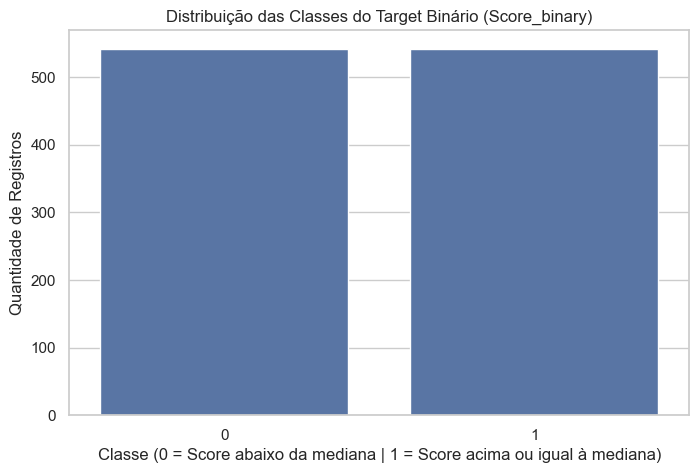

In [39]:
### 3.7 Balanceamento de classes (histograma)

# Plota o histograma das classes do target binário
sns.countplot(x="Score_binary", data=df_final)

# Ajustes do gráfico
plt.title("Distribuição das Classes do Target Binário (Score_binary)")
plt.xlabel("Classe (0 = Score abaixo da mediana | 1 = Score acima ou igual à mediana)")
plt.ylabel("Quantidade de Registros")

plt.show()



### 3.8 Distribuição estatística das principais features

Nesta etapa, iremos analisar a distribuição estatística das principais features
selecionadas para o projeto.

Serão utilizados histogramas para observar a forma da distribuição dos dados
e boxplots para identificar a presença de possíveis outliers nas variáveis.

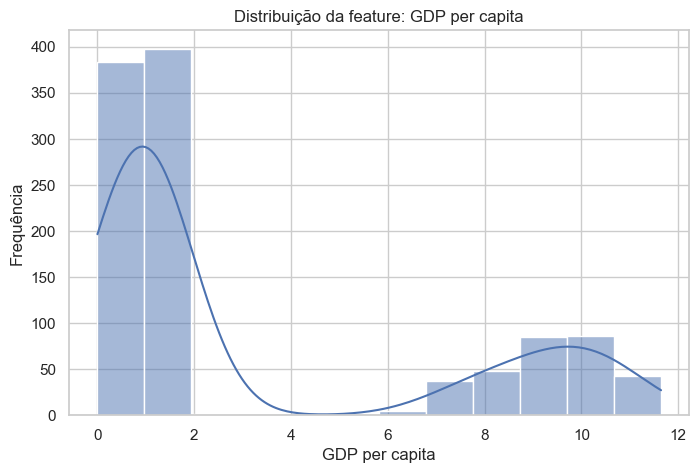

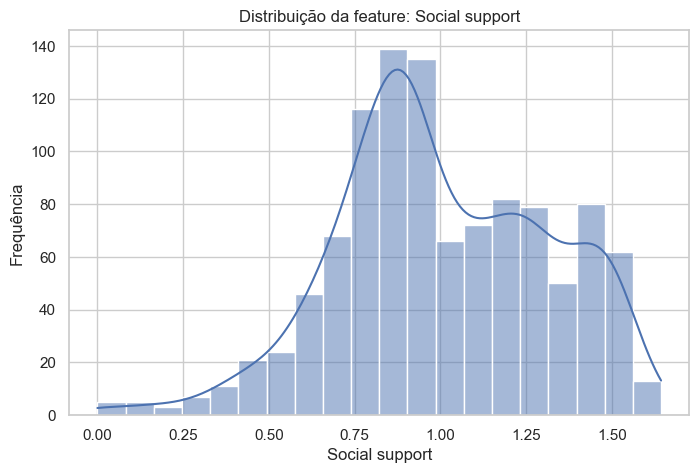

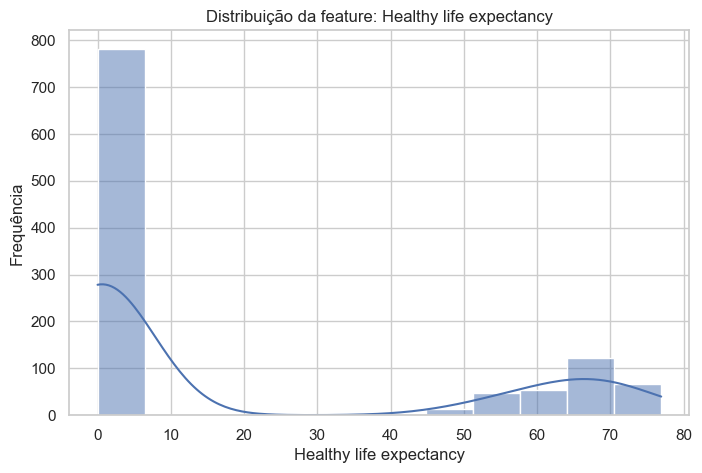

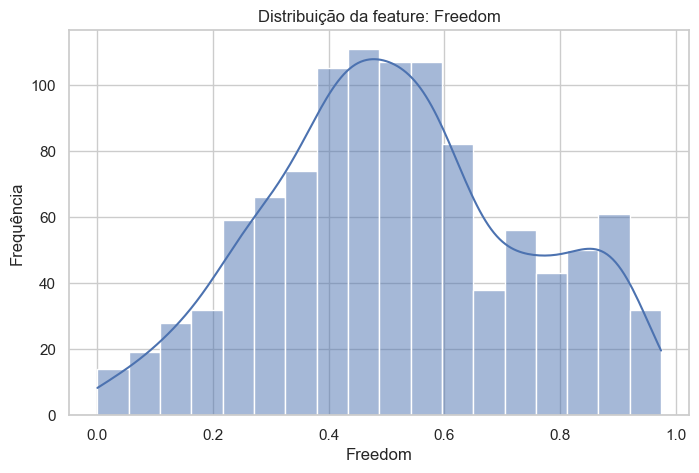

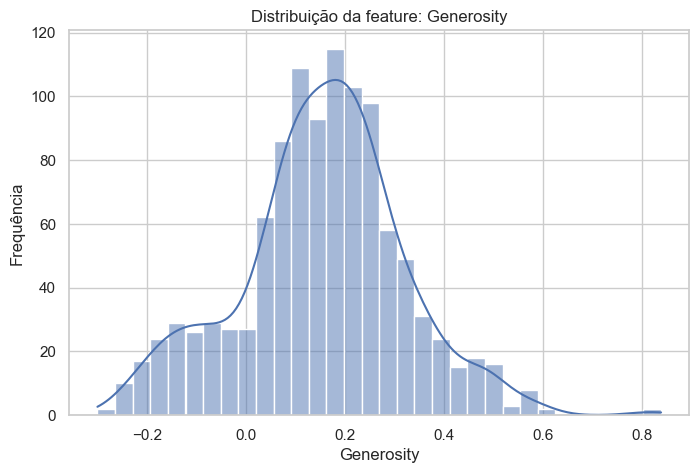

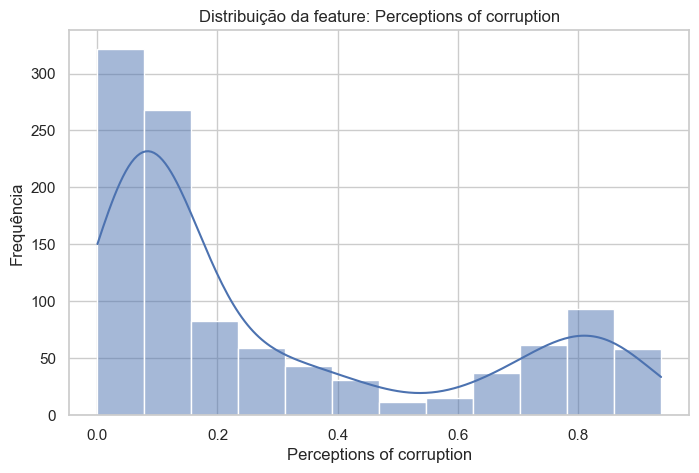

In [40]:
### 3.8 Distribuição estatística das principais features (histogramas)

# Lista das features numéricas selecionadas
features_numericas = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom",
    "Generosity",
    "Perceptions of corruption"
]

# Cria histogramas para cada feature
for feature in features_numericas:
    
    plt.figure()
    sns.histplot(df_final[feature], kde=True)
    plt.title(f"Distribuição da feature: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequência")
    plt.show()


### 3.9 Análise de Correlação (heatmap)

Nesta etapa, iremos analisar a correlação entre as principais variáveis numéricas
do dataframe, incluindo o target contínuo Score.

O objetivo é entender como as features se relacionam entre si e com o índice de
felicidade, auxiliando na interpretação dos dados e em decisões futuras sobre
seleção de variáveis.


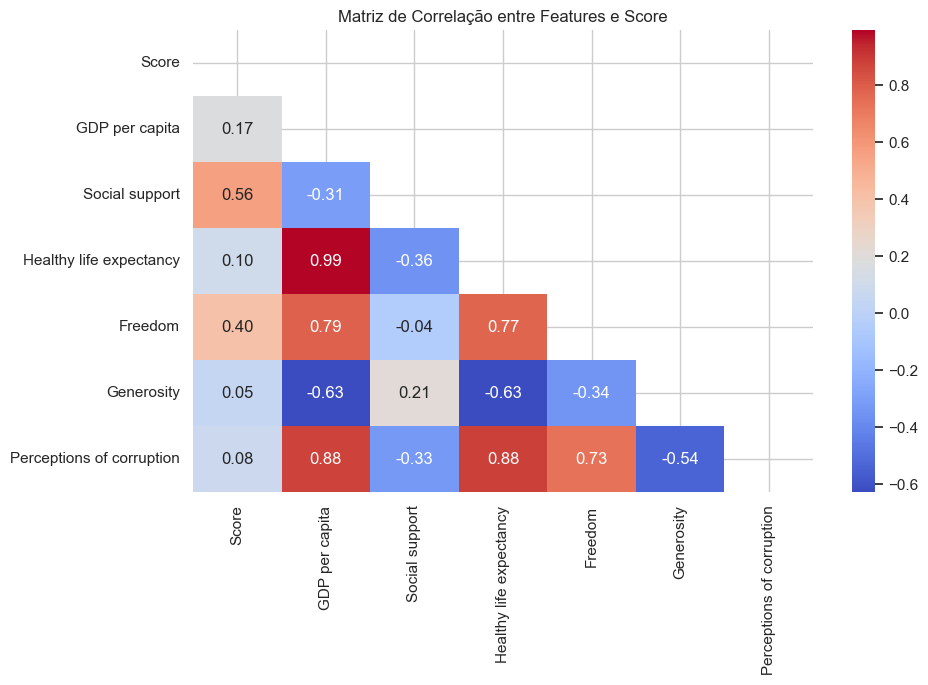

In [41]:
### 3.9 Análise de Correlação (heatmap - formato triangular)

# Seleciona as colunas numéricas para a correlação
colunas_correlacao = [
    "Score",
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom",
    "Generosity",
    "Perceptions of corruption"
]

# Calcula a matriz de correlação
matriz_corr = df_final[colunas_correlacao].corr()

# Cria uma máscara para ocultar a parte superior da matriz
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))

# Plota o heatmap em formato de escada
plt.figure(figsize=(10, 6))
sns.heatmap(
    matriz_corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Matriz de Correlação entre Features e Score")
plt.show()



### 4. Pré-processamento

Nesta etapa, iremos iniciar o pré-processamento dos dados, aplicando
transformações necessárias para preparar o conjunto de dados para o
treinamento dos modelos de Machine Learning.

A partir deste ponto, as operações realizadas passam a modificar os
dados, diferentemente da etapa de análise exploratória, que teve como
objetivo apenas compreender e organizar a estrutura do dataset.


### 4.1 Separação de features e target

Nesta etapa, iremos separar o conjunto de dados em features e target,
além de identificar quais colunas serão utilizadas no modelo.

As colunas de identificação e o target não serão utilizadas como
features, permanecendo apenas as variáveis numéricas que representam
os fatores associados ao índice de felicidade.


In [42]:
### 4.1 Separação de features e target

# Features (exclui target e colunas de identificação)
colunas_excluir = ["Score", "Score_binary", "Name", "Country"]
X = df_final.drop(columns=colunas_excluir)

# Target binário
y = df_final["Score_binary"]

# Identificação das colunas numéricas
colunas_numericas = X.columns.tolist()

# Exibe informações de conferência
print("Features utilizadas no modelo:")
for col in colunas_numericas:
    print(f"- {col}")

print("\nTarget:")
print("Score_binary")


Features utilizadas no modelo:
- GDP per capita
- Social support
- Healthy life expectancy
- Freedom
- Generosity
- Perceptions of corruption

Target:
Score_binary


### 4.2 Tratamento de dados ausentes (NaN)

Nesta etapa, iremos tratar os dados ausentes (NaN) presentes nas features,
preparando os dados para o treinamento dos modelos.

Para isso, serão utilizadas estratégias diferentes para features
numéricas e categóricas, aplicadas de forma automatizada por meio de um Pipeline,
evitando vazamento de dados.


In [43]:
### 4.2 Tratamento de dados ausentes (NaN)

# Para colunas numéricas (usa a mediana)
imputador_numerico = SimpleImputer(strategy="median")

# Para colunas categóricas (usa o valor mais frequente)
imputador_categorico = SimpleImputer(strategy="most_frequent")


### 4.3 Pipeline de pré-processamento

Após o tratamento de dados ausentes, iremos aplicar técnicas de
normalização e padronização nas features numéricas.


In [44]:
### 4.3 Pipeline de pré-processamento para features numéricas

# Pipeline para dados numéricos
pipeline_numerico = Pipeline(steps=[
    ("imputacao", imputador_numerico),
    ("scaler", StandardScaler())
])


### 5. Treinamento, Validação e Teste

Nesta etapa, iremos preparar os dados para o treinamento dos modelos de Machine Learning,
realizando a separação entre dados de treino e teste.

Em seguida, iremos treinar modelos de classificação binária utilizando o Pipeline
construído anteriormente, avaliando o desempenho dos modelos por meio de métricas
adequadas.


### 5.1 Split de Dados

Nesta etapa, iremos separar o conjunto de dados em treino e teste.
Essa separação permite treinar o modelo em uma parte dos dados e avaliar
seu desempenho em dados não vistos durante o treinamento.


In [45]:
### 5.1 Split de dados

# Features (já corrigidas)
colunas_excluir = ["Score", "Score_binary", "Name", "Country"]
X = df_final.drop(columns=colunas_excluir)

# Target
y = df_final["Score_binary"]

# Novo split
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### 5.2 Regressão Logística

Nesta etapa, iremos treinar um modelo de Regressão Logística para classificação
binária, utilizando o pipeline de pré-processamento definido anteriormente.

Esse modelo será utilizado como baseline, por ser simples, interpretável e
bastante utilizado como referência em problemas de classificação.

In [46]:
### 5.2 Pipeline completo e treinamento do modelo Regressão Logística

# Pipeline completo: pré-processamento + Regressão Logística
pipeline_logreg = Pipeline(steps=[
    ("preprocessamento", pipeline_numerico),
    ("modelo", LogisticRegression(max_iter=1000))
])

# Treinamento do modelo
pipeline_logreg.fit(X_treino, y_treino)


,steps,"[('preprocessamento', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputacao', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


### 5.3 KNN (K-Nearest Neighbors)

Nesta etapa, iremos treinar um modelo KNN (K-Nearest Neighbors) para classificação
binária.

Esse modelo baseia sua decisão na distância entre os registros, sendo sensível à
escala das variáveis. Por isso, o uso da padronização no pipeline é fundamental.

In [47]:
### 5.3 Pipeline completo e treinamento do modelo KNN

# Pipeline completo: pré-processamento + KNN
pipeline_knn = Pipeline(steps=[
    ("preprocessamento", pipeline_numerico),
    ("modelo", KNeighborsClassifier(n_neighbors=5))
])

# Treinamento do modelo
pipeline_knn.fit(X_treino, y_treino)

,steps,"[('preprocessamento', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputacao', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


### 5.4 Random Forest

Nesta etapa, iremos treinar um modelo de Random Forest, que é um algoritmo
baseado em múltiplas árvores de decisão.

Esse modelo é capaz de capturar relações não lineares entre as variáveis e, em geral,
apresenta bom desempenho em problemas de classificação.

In [48]:
### 5.4 Pipeline completo e treinamento do modelo Random Forest

# Pipeline completo: pré-processamento + Random Forest
pipeline_rf = Pipeline(steps=[
    ("preprocessamento", pipeline_numerico),
    ("modelo", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

# Treinamento do modelo
pipeline_rf.fit(X_treino, y_treino)

,steps,"[('preprocessamento', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputacao', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


### 5.5 Teste dos Modelos

Após o treinamento, iremos avaliar o desempenho dos modelos de classificação
no conjunto de teste, que não foi utilizado durante o treinamento.

Serão testados os seguintes modelos:
- Regressão Logística
- KNN (K-Nearest Neighbors)
- Random Forest

Nesta etapa, iremos observar as métricas de classificação de cada modelo,
sem ainda realizar uma comparação formal entre eles, que será feita em uma
etapa posterior.



In [49]:
### 5.5 Teste dos Modelos

# Dicionário com os modelos treinados
modelos = {
    "Regressão Logística": pipeline_logreg,
    "KNN": pipeline_knn,
    "Random Forest": pipeline_rf
}

# Loop para testar cada modelo
for nome, modelo in modelos.items():
    
    print(f"\nModelo: {nome}")
    print("-" * 40)
    
    # Predições
    y_pred = modelo.predict(X_teste)
    
    # Relatório de classificação
    print(classification_report(y_teste, y_pred))




Modelo: Regressão Logística
----------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       109
           1       0.77      0.80      0.79       108

    accuracy                           0.78       217
   macro avg       0.78      0.78      0.78       217
weighted avg       0.78      0.78      0.78       217


Modelo: KNN
----------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       109
           1       0.83      0.81      0.82       108

    accuracy                           0.82       217
   macro avg       0.82      0.82      0.82       217
weighted avg       0.82      0.82      0.82       217


Modelo: Random Forest
----------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       109
           1       0.87      0.81      0.84      

### 6. Otimização de Modelos (Fine Tuning)

Nesta etapa, iremos realizar a otimização de hiperparâmetros (fine tuning)
em modelos selecionados, com o objetivo de melhorar o desempenho obtido
na etapa de treinamento inicial.

Como estratégia, o processo de otimização será aplicado apenas ao modelo
Random Forest, que possui maior número de hiperparâmetros ajustáveis.
Os demais modelos serão mantidos com seus parâmetros padrão,
servindo como base de comparação.



### 6.1 Otimização de hiperparâmetros do Random Forest

Nesta etapa, iremos aplicar a técnica de Grid Search para testar diferentes
combinações de hiperparâmetros do modelo Random Forest.

A métrica utilizada para avaliação será a AUC (Area Under the Curve),
calculada por meio de validação cruzada.



In [50]:
### 6.1 Otimização de hiperparâmetros do Random Forest

from sklearn.model_selection import GridSearchCV

# Espaço de busca de hiperparâmetros
param_grid_rf = {
    "modelo__n_estimators": [100, 200],
    "modelo__max_depth": [None, 10, 20],
    "modelo__min_samples_split": [2, 5]
}

# Pipeline base do Random Forest
pipeline_rf_base = Pipeline(steps=[
    ("preprocessamento", pipeline_numerico),
    ("modelo", RandomForestClassifier(random_state=42))
])

# Grid Search
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf_base,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Treinamento do Grid Search
grid_search_rf.fit(X_treino, y_treino)

# Melhor modelo encontrado
pipeline_rf_otimizado = grid_search_rf.best_estimator_

# Exibe os melhores parâmetros
print("Melhores hiperparâmetros encontrados:")
print(grid_search_rf.best_params_)



Melhores hiperparâmetros encontrados:
{'modelo__max_depth': None, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 200}


### 7. Avaliação de Modelos

Nesta etapa, iremos avaliar o desempenho dos modelos treinados
utilizando o conjunto de teste.

Serão aplicadas métricas adequadas a problemas de classificação binária,
permitindo analisar a capacidade dos modelos em distinguir corretamente
os registros pertencentes às duas classes do target.


### 7.1 Geração de previsões no conjunto de teste

Nesta etapa, iremos gerar as previsões dos modelos para o conjunto de teste,
obtendo tanto as classes previstas quanto as probabilidades associadas
à classe positiva.


In [51]:
### 7.1 Geração de previsões no conjunto de teste

# Dicionário com os modelos avaliados
modelos_avaliacao = {
    "Regressão Logística": pipeline_logreg,
    "KNN": pipeline_knn,
    "Random Forest (Otimizado)": pipeline_rf_otimizado
}

# Avaliação dos modelos
for nome, modelo in modelos_avaliacao.items():
    
    print(f"\nModelo: {nome}")
    print("-" * 40)
    
    y_pred = modelo.predict(X_teste)
    
    print(classification_report(y_teste, y_pred))



Modelo: Regressão Logística
----------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       109
           1       0.77      0.80      0.79       108

    accuracy                           0.78       217
   macro avg       0.78      0.78      0.78       217
weighted avg       0.78      0.78      0.78       217


Modelo: KNN
----------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       109
           1       0.83      0.81      0.82       108

    accuracy                           0.82       217
   macro avg       0.82      0.82      0.82       217
weighted avg       0.82      0.82      0.82       217


Modelo: Random Forest (Otimizado)
----------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       109
           1       0.90      0.84    

### 7.2 Matriz de Confusão

Nesta etapa, iremos analisar a matriz de confusão de cada modelo,
que permite visualizar a quantidade de acertos e erros de classificação,
considerando verdadeiros positivos, verdadeiros negativos,
falsos positivos e falsos negativos.



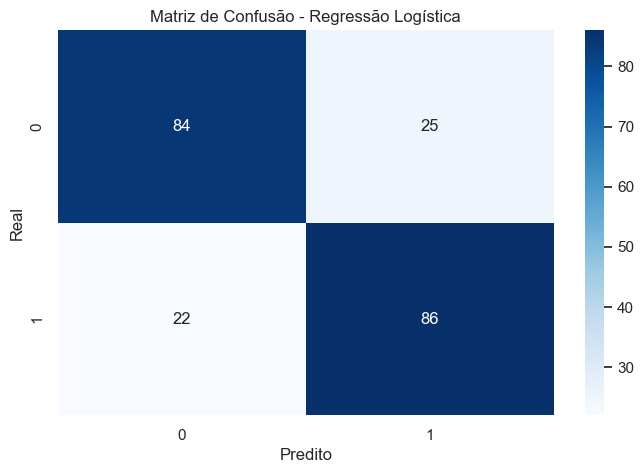

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       109
           1       0.77      0.80      0.79       108

    accuracy                           0.78       217
   macro avg       0.78      0.78      0.78       217
weighted avg       0.78      0.78      0.78       217



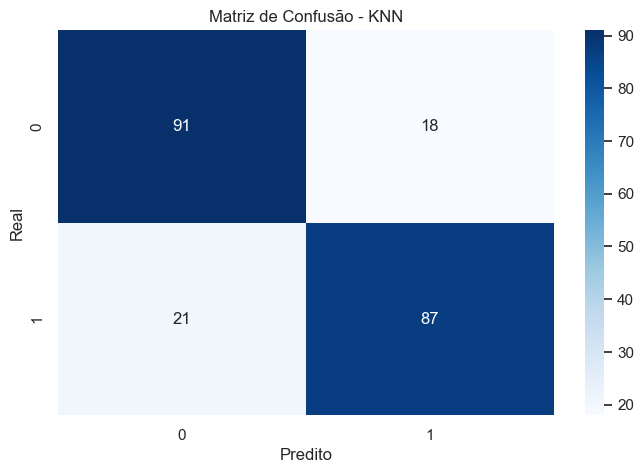

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       109
           1       0.83      0.81      0.82       108

    accuracy                           0.82       217
   macro avg       0.82      0.82      0.82       217
weighted avg       0.82      0.82      0.82       217



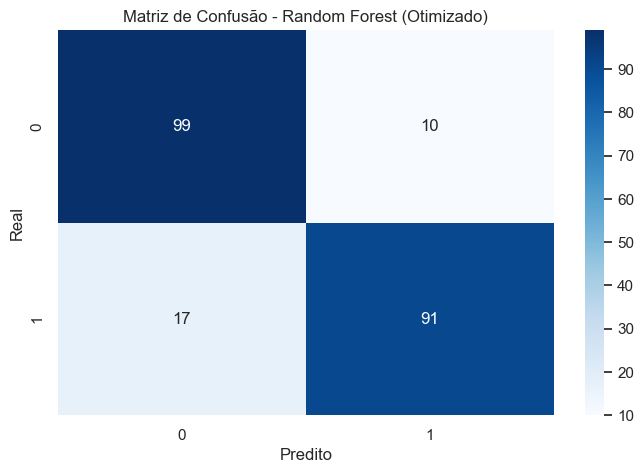

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       109
           1       0.90      0.84      0.87       108

    accuracy                           0.88       217
   macro avg       0.88      0.88      0.88       217
weighted avg       0.88      0.88      0.88       217



In [52]:
### 7.2 Matriz de Confusão

for nome, modelo in modelos_avaliacao.items():
    
    y_pred = modelo.predict(X_teste)
    cm = confusion_matrix(y_teste, y_pred)
    
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()
    print(classification_report(y_teste, y_pred))



### 8. Comparativo de Performances dos Modelos

Nesta etapa, iremos comparar o desempenho dos modelos de classificação
por meio da Curva ROC (Receiver Operating Characteristic) e da métrica
AUC (Area Under the Curve).

Essa análise permite avaliar a capacidade discriminatória de cada modelo
em diferentes limiares de decisão e identificar aquele com melhor
desempenho global.



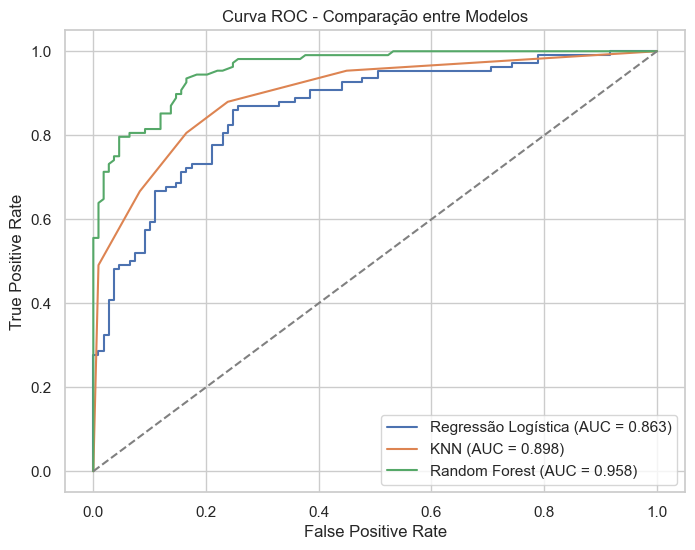

,AUC
Random Forest,0.957569
KNN,0.898488
Regressão Logística,0.862640


In [53]:
### 8. Comparativo de Performances dos Modelos

# Dicionário com os modelos treinados
modelos = {
    "Regressão Logística": pipeline_logreg,
    "KNN": pipeline_knn,
    "Random Forest": pipeline_rf
}

plt.figure(figsize=(8, 6))

resultados_auc = {}

for nome, modelo in modelos.items():
    
    y_proba = modelo.predict_proba(X_teste)[:, 1]
    auc = roc_auc_score(y_teste, y_proba)
    fpr, tpr, _ = roc_curve(y_teste, y_proba)
    
    resultados_auc[nome] = auc
    
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.3f})")

# Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação entre Modelos")
plt.legend()
plt.show()

# Tabela resumo de desempenho
df_resultados = pd.DataFrame.from_dict(
    resultados_auc,
    orient="index",
    columns=["AUC"]
).sort_values(by="AUC", ascending=False)

df_resultados



### 9. Explicabilidade do Modelo (Extra)

Nesta etapa, foi realizada uma tentativa de aplicação de técnicas de
explicabilidade para interpretar as decisões do modelo Random Forest,
utilizando a biblioteca SHAP.

Devido à complexidade do pipeline de pré-processamento e às transformações
aplicadas aos dados, a interpretação direta dos valores SHAP apresentou
limitações técnicas. Ainda assim, a etapa permitiu compreender a importância
da explicabilidade em modelos de Machine Learning e reforçou a análise das
features mais relevantes para o problema estudado.


### 9.1 Seleção do modelo para explicabilidade

Para a análise de explicabilidade, será utilizado o modelo Random Forest
otimizado, por apresentar bom desempenho e permitir a extração de
importâncias das features de forma robusta.

A explicabilidade será realizada sobre o conjunto de treino, evitando
qualquer vazamento de informação do conjunto de teste.



In [54]:
### 9.1 Seleção do modelo para explicabilidade

# Seleciona o modelo Random Forest treinado dentro do pipeline
modelo_rf = pipeline_rf_otimizado.named_steps["modelo"]


### 9.2 Preparação dos dados para explicabilidade

Como o modelo foi treinado a partir de dados transformados pelo pipeline
de pré-processamento (imputação e padronização), é necessário aplicar as
mesmas transformações ao conjunto de treino antes de calcular os valores
de SHAP.

Essa etapa garante compatibilidade entre os dados utilizados na
explicação e o modelo treinado.


In [55]:
### 9.2 Preparação dos dados para explicabilidade

# Aplica o pré-processamento do pipeline ao conjunto de treino
X_treino_processado = pipeline_rf_otimizado.named_steps[
    "preprocessamento"
].transform(X_treino)




### 9.3 Cálculo dos valores de SHAP

Nesta etapa, iremos calcular os valores de SHAP (SHapley Additive
exPlanations), que representam a contribuição de cada feature para a
predição do modelo.

Será utilizado o TreeExplainer, apropriado para modelos baseados em
árvores, como o Random Forest.


In [56]:
### 9.3 Cálculo dos valores de SHAP

# Recria o explicador SHAP usando o modelo treinado-++++++++
import shap

modelo_rf = pipeline_rf_otimizado.named_steps["modelo"]

explainer = shap.Explainer(
    modelo_rf.predict_proba,
    X_treino_processado
)

In [57]:
shap_values = explainer(X_treino_processado)


ExactExplainer explainer: 868it [01:06, 10.89it/s]                         


### 9.4 Importância global das features

Nesta etapa, iremos analisar a importância global das features utilizando
o gráfico Summary Plot do SHAP.

Esse gráfico mostra quais variáveis mais impactam as previsões do modelo,
bem como a direção e a intensidade dessa influência.


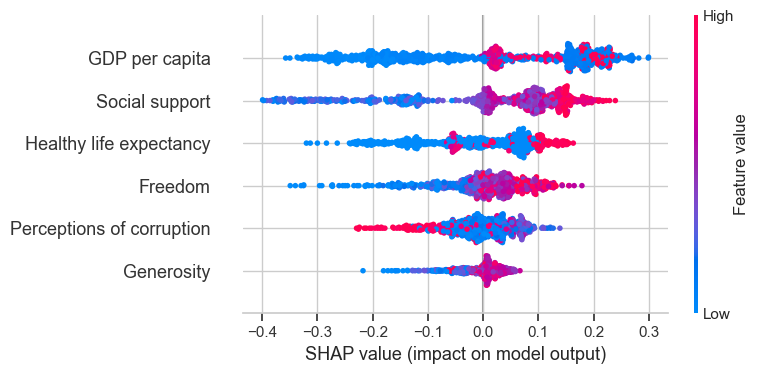

In [58]:
### 9.4 Importância global das features

# Gráfico de importância global das features
shap.summary_plot(
    shap_values.values[:, :, 1],  # classe positiva
    X_treino_processado,
    feature_names=colunas_numericas
)



### 9.5 Interpretação dos resultados

A análise dos valores de SHAP permite identificar quais fatores possuem
maior influência nas decisões do modelo.

Features com maiores valores absolutos de SHAP indicam maior impacto na
classificação do índice de felicidade, contribuindo positivamente ou
negativamente para a previsão da classe associada a maior nível de
felicidade.

Essa análise complementa as métricas quantitativas avaliadas nas etapas
anteriores, fornecendo uma visão mais interpretável do comportamento do
modelo.


### Conclusão Final e Storytelling do Projeto

Neste projeto, aplicamos técnicas de Machine Learning para analisar fatores
associados ao índice de felicidade dos países, utilizando dados do World Happiness Report.

Como o índice de felicidade é originalmente uma variável contínua, optamos por
transformar o problema em uma tarefa de classificação binária, criando um rótulo
a partir da mediana do Score. Essa abordagem permitiu comparar países com níveis
relativamente mais altos e mais baixos de felicidade.

Um dos principais desafios do projeto foi a padronização dos dados, uma vez que
os arquivos do dataset apresentam diferenças nos nomes das colunas ao longo dos anos.
Esse problema foi resolvido por meio de uma etapa de padronização dos rótulos,
permitindo a unificação dos dados em um único dataframe com mais de 1000 instâncias.

Foram treinados três modelos de classificação binária: Regressão Logística,
K-Nearest Neighbors (KNN) e Random Forest. O desempenho dos modelos foi avaliado
por meio de métricas adequadas, como matriz de confusão, relatório de classificação
e Curva ROC com AUC.

Os resultados mostraram que o modelo Random Forest apresentou o melhor desempenho
geral, indicando maior capacidade de capturar relações não lineares entre as
variáveis explicativas. A análise comparativa reforçou a importância de avaliar
diferentes algoritmos para um mesmo problema.

De forma geral, o projeto demonstrou como técnicas de Machine Learning podem ser
aplicadas para compreender padrões associados ao bem-estar dos países, além de
evidenciar a importância de uma boa organização da pipeline e da análise
exploratória dos dados.
